In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import glob

In [4]:
PATH = "data/Monkeys/"
sz=224
train_path = PATH + '/train'
val_path = PATH + '/valid'

In [5]:
os.listdir(PATH)

['sample',
 'tmp',
 'Label.txt',
 'models',
 '.ipynb_checkpoints',
 'valid',
 'train']

In [6]:
os.listdir(PATH + 'valid')

['n0', 'n9', 'n8', 'n4', 'n3', 'n6', 'n2', 'n7', 'n5', 'n1']

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [8]:
cuda.set_device(7)

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.backends.cudnn.enabled

True

In [11]:
def get_nrof_images_of_classes(path):
    dic = {}
    class_names = [os.path.basename(x) for x in glob.glob(path + '/*')]
    for class_name in class_names:
        dic[class_name] = len(glob.glob(path + '/' + class_name + '/*'))
    return dic

In [12]:
def plot_nrof_images_histogram(path):
    nrof_images_of_train_classes = get_nrof_images_of_classes(path)
    values = nrof_images_of_train_classes.values()
    f = plt.figure(figsize=(20,5))
    plt.bar(range(len(values)), values)
    plt.show()

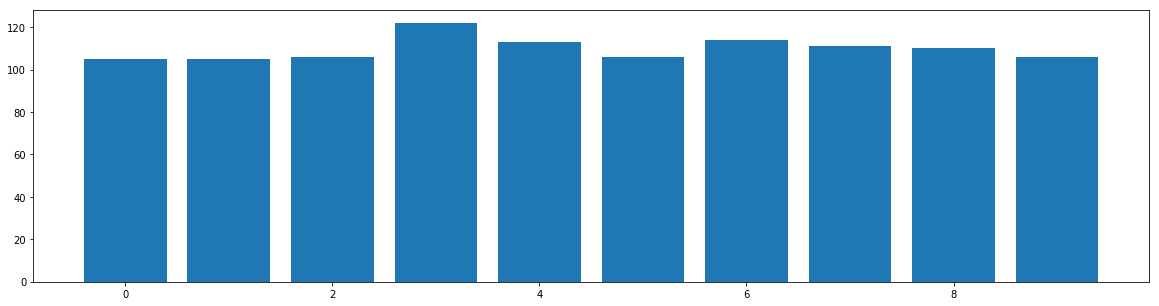

In [13]:
plot_nrof_images_histogram(train_path)

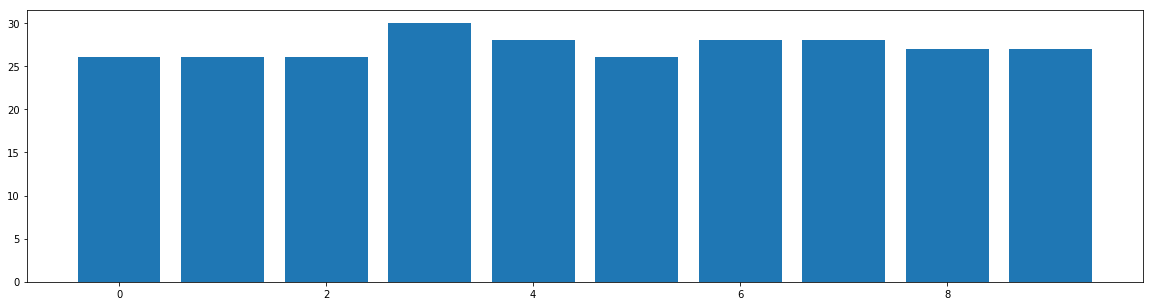

In [14]:
plot_nrof_images_histogram(val_path)

In [15]:
model = resnet34

In [16]:
tfms = tfms_from_model(model, sz)

In [17]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [18]:
learner = ConvLearner.pretrained(model, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 53237079.90it/s]


In [19]:
lrs = learner.lr_find()

epoch      trn_loss   val_loss   accuracy                
    0      2.033391   102.152321 0.4375    



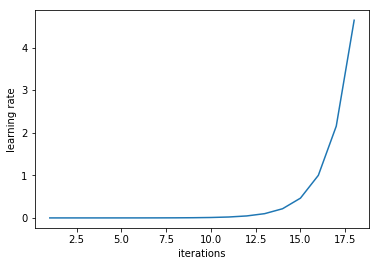

In [20]:
learner.sched.plot_lr()

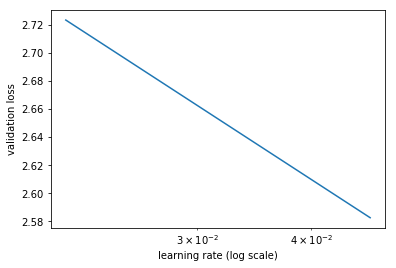

In [21]:
learner.sched.plot()

In [22]:
learner.fit(lrs=0.035 ,n_cycle=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.722399   0.049575   0.988971  



[0.04957455046036664, 0.9889705882352942]

In [23]:
preds = np.argmax(learner.predict(), axis=1)
accuracy = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
accuracy

0.9889705882352942

In [24]:
def plots(ims, figsize=(15,15), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    num_in_figure = len(ims) // rows * rows
    num_row = rows
    if num_in_figure < len(ims):
        num_row += 1
    for i in range(num_in_figure):
        sp = f.add_subplot(num_row, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

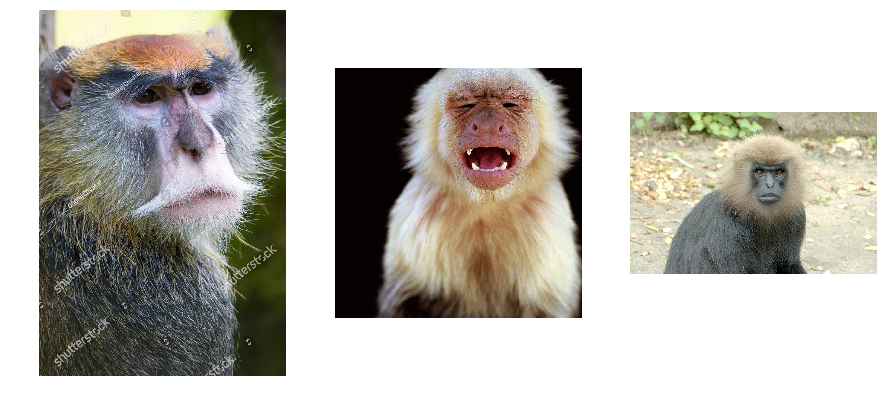

In [25]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=1)

In [26]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  48 : Actual class:  n1 - Predict class:  n3
Test image  151 : Actual class:  n5 - Predict class:  n6
Test image  252 : Actual class:  n9 - Predict class:  n3


In [27]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1, val_name='valid')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [28]:
ims = np.stack([get_augs() for i in range(6)])

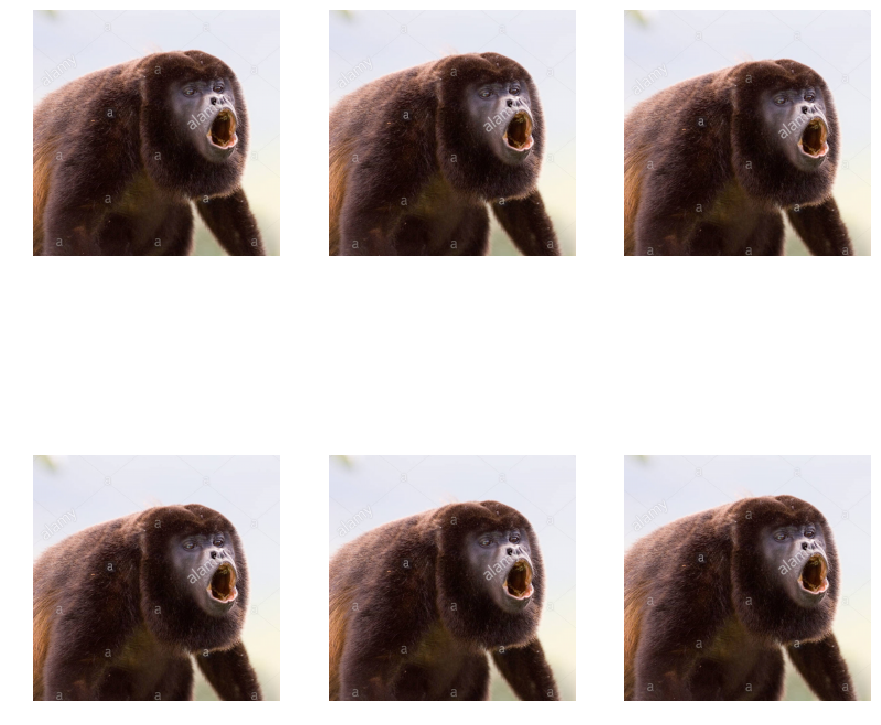

In [29]:
plots(ims, rows=2)

In [30]:
learner.precompute=False

In [31]:
learner.fit( 0.035, n_cycle=3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.111146   0.039257   0.996324  
    1      0.099973   0.040005   0.988971                   
    2      0.087501   0.030081   0.992647                   



[0.03008098725010367, 0.9926470588235294]

In [32]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y)
acc

0.9926470588235294

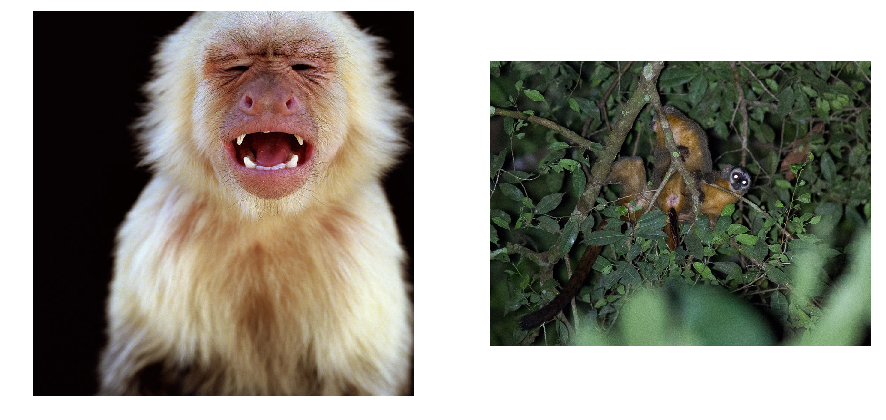

In [33]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=1)

In [34]:
learner.unfreeze()

In [35]:
lr = 0.035
lrs=np.array([lr/500, lr/50, lr])

In [36]:
learner.fit(lrs=lrs, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.196013   0.038541   0.992647  
    1      0.137111   0.042921   0.992647                  
    2      0.118865   0.028111   0.996324                  
    3      0.091431   0.034225   0.996324                   
    4      0.076898   0.025255   0.996324                   
    5      0.064443   0.027186   0.996324                   



[0.02718609746764688, 0.9963235294117647]

In [37]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); 
acc

0.9963235294117647

In [38]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]

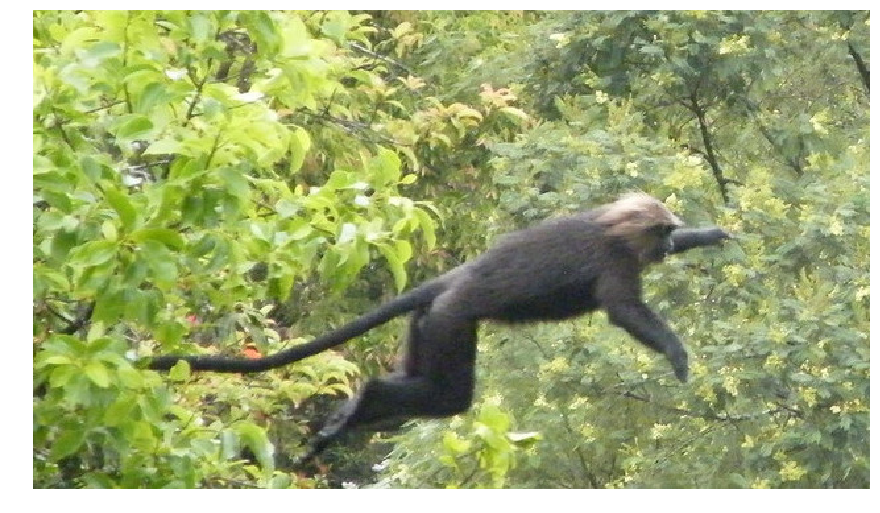

In [49]:
plots(false_classify_images, rows=1)

In [50]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  268 : Actual class:  n9 - Predict class:  n0


In [51]:
import matplotlib.image as mpimg

In [52]:
def plot_actual_image_vs_predict_class(image_num):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(data.val_ds.get_x(image_num))
    axes[0].set(title='Actual image')
    predict_class_sample_image = random.choice(glob.glob(train_path + '/' + data.classes[preds[image_num]] + '/*'))
    img = mpimg.imread(predict_class_sample_image)
    axes[1].imshow(img)
    axes[1].set(title='Predict class')
    plt.show()

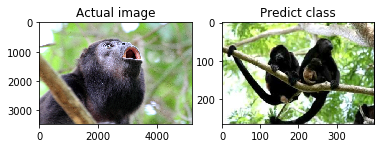

In [53]:
i = np.random.randint(len(false_classify))
plot_actual_image_vs_predict_class(i)

In [54]:
learner.lr_find()

 83%|████████▎ | 15/18 [00:11<00:02,  1.32it/s, loss=0.0687]

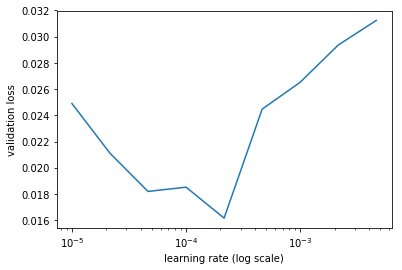

In [56]:
learner.sched.plot(0)

In [57]:
learner.fit(lrs=0.0004, n_cycle=2, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.038538   0.025799   1.0       
    1      0.037944   0.022002   1.0                        
    2      0.037819   0.020097   1.0                        
    3      0.038326   0.020555   1.0                        
    4      0.035515   0.021716   0.996324                   
    5      0.032489   0.020877   0.996324                   


[0.020877420025713304, 0.9963235294117647]

In [60]:
learner.fit(lrs=0.0004, n_cycle=1, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   accuracy                   
    0      0.042058   0.022347   0.996324  


[0.02234658511245952, 0.9963235294117647]

In [61]:
preds = np.argmax(learner.predict(), axis=1)
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9963235294117647

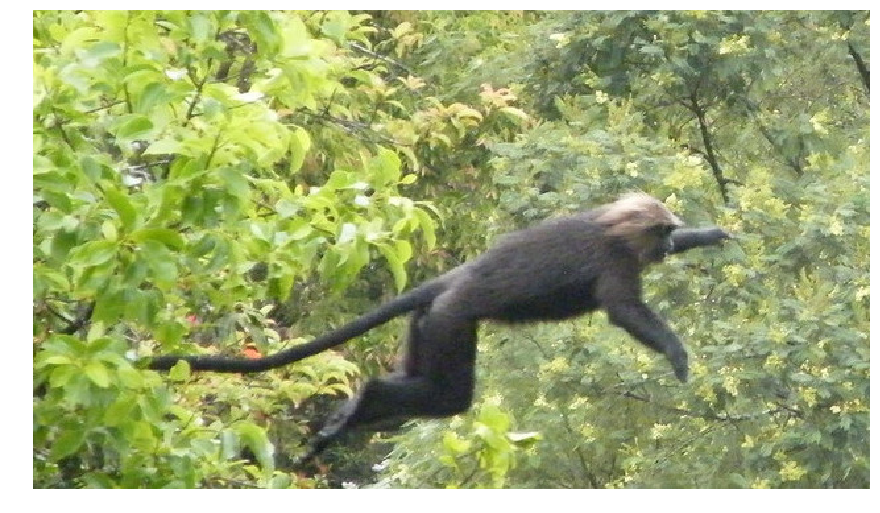

In [64]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=1)

In [65]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  268 : Actual class:  n9 - Predict class:  n0


In [66]:
preds_tta, y = learner.TTA()

In [67]:
preds = np.argmax(np.mean(preds_tta, 0), axis=1)

In [68]:
acc = len(np.where((preds==data.val_ds.y)==True)[0]) / len(data.val_ds.y); acc

0.9963235294117647

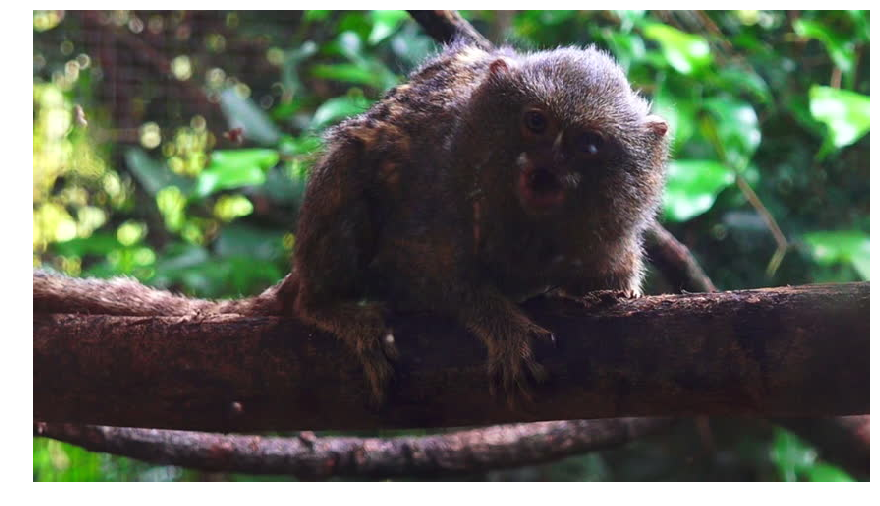

In [70]:
false_classify = np.where((preds==data.val_ds.y)==False)[0]
false_classify_images = [data.val_ds.get_x(ids) for ids in false_classify]
plots(false_classify_images, rows=1)

In [71]:
for i in range(len(false_classify)):
    print('Test image ', false_classify[i], ': Actual class: ',data.classes[data.val_ds.y[false_classify[i]]], '- Predict class: ', data.classes[preds[false_classify[i]]])

Test image  120 : Actual class:  n4 - Predict class:  n0


In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[26  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 1  0  0  0 25  0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0]
 [ 0  0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 26]]


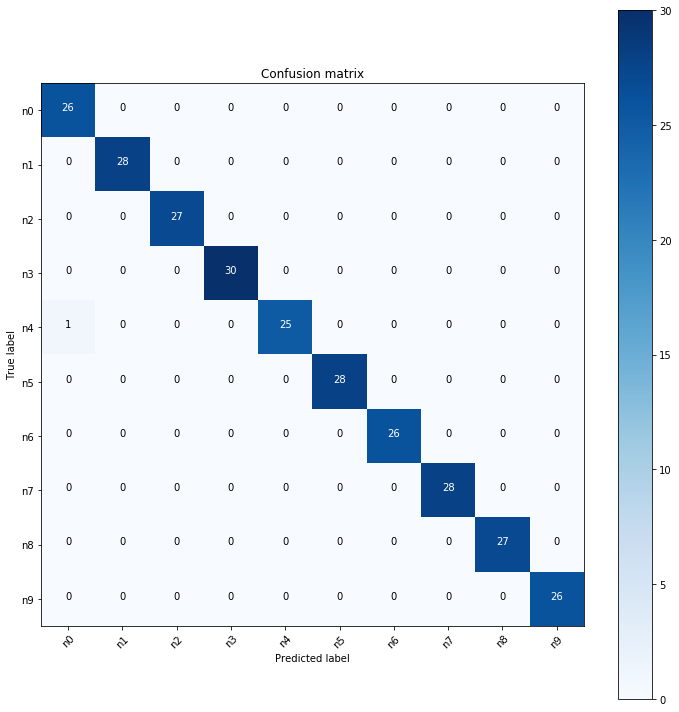

In [73]:
plot_confusion_matrix(cm, data.classes, figsize=(10,10))